<p style="font-family: Arial; font-size:2.75em;color:purple; font-style:bold"><br>

Clustering with scikit-learn

<br><br></p>

In this notebook, we will learn how to perform k-means clustering using scikit-learn in Python. 

We will use cluster analysis to generate a big picture model of the weather at a local station using a minute-graunlarity data. In this dataset, we have in the order of millions records. How do we create 12 clusters out of them?

**NOTE:** The dataset we will use is in a large CSV file called *minute_weather.csv*. Please download it into the *weather* directory in your *Week-7-MachineLearning* folder. The download link is: https://drive.google.com/open?id=0B8iiZ7pSaSFZb3ItQ1l4LWRMTjg 

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Importing the Necessary Libraries<br></p>

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
# import utils
import pandas as pd
import numpy as np
from itertools import cycle, islice
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

%matplotlib inline

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Creating a Pandas DataFrame from a CSV file<br><br></p>


In [71]:
data = pd.read_csv('./weather/minute_weather.csv')

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold">Minute Weather Data Description</p>
<br>
The **minute weather dataset** comes from the same source as the daily weather dataset that we used in the decision tree based classifier notebook. The main difference between these two datasets is that the minute weather dataset contains raw sensor measurements captured at one-minute intervals. Daily weather dataset instead contained processed and well curated data. The data is in the file **minute_weather.csv**, which is a comma-separated file.

As with the daily weather data, this data comes from a weather station located in San Diego, California. The weather station is equipped with sensors that capture weather-related measurements such as air temperature, air pressure, and relative humidity. Data was collected for a period of three years, from September 2011 to September 2014, to ensure that sufficient data for different seasons and weather conditions is captured.

Each row in **minute_weather.csv** contains weather data captured for a one-minute interval. Each row, or sample, consists of the following variables:

* **rowID:** 	unique number for each row	(*Unit: NA*)
* **hpwren_timestamp:**	timestamp of measure	(*Unit: year-month-day hour:minute:second*)
* **air_pressure:** air pressure measured at the timestamp	(*Unit: hectopascals*)
* **air_temp:**	air temperature measure at the timestamp	(*Unit: degrees Fahrenheit*)
* **avg_wind_direction:**	wind direction averaged over the minute before the timestamp	(*Unit: degrees, with 0 means coming from the North, and increasing clockwise*)
* **avg_wind_speed:**	wind speed averaged over the minute before the timestamp	(*Unit: meters per second*)
* **max_wind_direction:**	highest wind direction in the minute before the timestamp	(*Unit: degrees, with 0 being North and increasing clockwise*)
* **max_wind_speed:**	highest wind speed in the minute before the timestamp	(*Unit: meters per second*)
* **min_wind_direction:**	smallest wind direction in the minute before the timestamp	(*Unit: degrees, with 0 being North and inceasing clockwise*)
* **min_wind_speed:**	smallest wind speed in the minute before the timestamp	(*Unit: meters per second*)
* **rain_accumulation:**	amount of accumulated rain measured at the timestamp	(*Unit: millimeters*)
* **rain_duration:**	length of time rain has fallen as measured at the timestamp	(*Unit: seconds*)
* **relative_humidity:**	relative humidity measured at the timestamp	(*Unit: percent*)

In [72]:
data.shape

(1048575, 13)

In [73]:
data.head()

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
0,0,9/10/11 0:00,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,NaN,NaN,60.5
1,1,9/10/11 0:01,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,0.0,0.0,39.9
2,2,9/10/11 0:02,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,0.0,0.0,43.0
3,3,9/10/11 0:03,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,0.0,0.0,49.5
4,4,9/10/11 0:04,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,0.0,0.0,58.8


In [74]:
airPressure = data['air_pressure'].unique().tolist()
len(airPressure)

246

In [75]:
airTemp = data['air_pressure'].unique().tolist()
len(airTemp)

246

In [76]:
years = data['hpwren_timestamp'].unique().tolist()
len(years)

1015776

In [77]:
print(min(years)," to ",max(years))

1/1/12 0:00  to  9/9/12 9:59


<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Data Sampling<br></p>

Lots of rows, so let us sample down by taking every 10th row. <br>


In [78]:
sampled_df = data[(data['rowID'] % 10) == 0]
sampled_df.shape

(104858, 13)

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Statistics
<br><br></p>


The transpose operation 
turns the columns into rows and vice versa,
the rows into columns.

In [79]:
sampled_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rowID,104858.0,524285.000000,302700.416006,0.00,262142.5,524285.0,786427.50,1048570.00
air_pressure,104858.0,916.896735,3.086510,905.00,914.8,916.7,918.80,929.50
air_temp,104858.0,60.882900,12.029025,31.64,51.8,60.8,69.98,99.50
avg_wind_direction,104832.0,161.828316,95.869734,0.00,62.0,182.0,217.00,359.00
avg_wind_speed,104832.0,2.750766,2.016746,0.00,1.3,2.2,3.80,31.90
max_wind_direction,104832.0,162.626335,92.715477,0.00,67.0,187.0,223.00,359.00
max_wind_speed,104832.0,3.370356,2.361040,0.10,1.6,2.7,4.50,32.20
min_wind_direction,104832.0,166.937738,98.010987,0.00,76.0,180.0,212.00,359.00
min_wind_speed,104832.0,2.118886,1.719259,0.00,0.8,1.6,3.00,31.60
rain_accumulation,104857.0,0.000318,0.007715,0.00,0.0,0.0,0.00,1.17


In [80]:
sampled_df[sampled_df['rain_accumulation'] == 0].shape

(104152, 13)

In [81]:
sampled_df[sampled_df['rain_duration'] == 0].shape

(103726, 13)

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Drop all the Rows with Empty rain_duration and rain_accumulation
<br><br></p>


In [82]:
del sampled_df['rain_accumulation']
del sampled_df['rain_duration']

In [83]:
rows_before = sampled_df.shape[0]
sampled_df = sampled_df.dropna()
rows_after = sampled_df.shape[0]

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

How many rows did we drop ?
<br><br></p>


In [84]:
rows_before - rows_after

26

In [85]:
sampled_df.columns

Index(['rowID', 'hpwren_timestamp', 'air_pressure', 'air_temp',
       'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction',
       'max_wind_speed', 'min_wind_direction', 'min_wind_speed',
       'relative_humidity'],
      dtype='object')

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Select Features of Interest for Clustering
<br><br></p>


In [86]:
features = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 
        'max_wind_speed','relative_humidity']

In [87]:
select_df = sampled_df[features]

In [88]:
select_df.columns

Index(['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed',
       'max_wind_direction', 'max_wind_speed', 'relative_humidity'],
      dtype='object')

In [89]:
select_df

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity
0,912.3,64.76,97.0,1.2,106.0,1.6,60.5
10,912.3,62.24,144.0,1.2,167.0,1.8,38.5
20,912.2,63.32,100.0,2.0,122.0,2.5,58.3
30,912.2,62.60,91.0,2.0,103.0,2.4,57.9
40,912.2,64.04,81.0,2.6,88.0,2.9,57.4
50,912.1,63.68,102.0,1.2,119.0,1.5,51.4
60,912.0,64.04,83.0,0.7,101.0,0.9,51.4
70,911.9,64.22,82.0,2.0,97.0,2.4,62.2
80,911.9,61.70,67.0,3.3,70.0,3.5,71.5
90,911.9,61.34,67.0,3.6,75.0,4.2,72.5


<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Scale the Features using StandardScaler
<br><br></p>


To keep values of different columns comparable,
we scale the values in these features.
So we will use standard scaler for that. The idea behind StandardScaler is that it will transform your data such that its distribution will have a mean value 0 and standard deviation of 1.
<br><br>
It's an object, and if we give a dataFrame to it,
to a function of it in this case,
we'll get a nicely scaled input data
for our clustering operation.
So we have the standard scaler,
and we use the fit_transform function of it,
and we give the select_df
as an input to that. The fit_transform function here combines
fit and transform operations,
which means it first calculates how much
the data set should be transformed to be scaled.
So it looks at different values and finds
how to scale that.
Then it's going to apply that transformation
to the data frame we give it, in this case select_df,
and it's gonna apply the transformation it came up with
to that data frame.
We will assign the output of this function to X,
just like we did here,
and that X that we are creating in a nicely scaled fashion will be an input for our k-Means modeling later.
<br><br>
They are not the same values here anymore,
they are at the certain scale between a minimum
and a maximum number.

In [90]:
X = StandardScaler().fit_transform(select_df)
X

array([[-1.48932625,  0.32206717, -0.67621576, ..., -0.61075677,
        -0.74982427,  0.44601437],
       [-1.48932625,  0.11256717, -0.18596485, ...,  0.0471732 ,
        -0.66511542, -0.39916312],
       [-1.52172555,  0.20235289, -0.64492315, ..., -0.43818498,
        -0.36863444,  0.36149662],
       ..., 
       [-0.06375737,  1.48928149,  0.26256257, ...,  0.28445941,
        -1.17336853, -1.55167787],
       [-0.09615666,  1.48928149,  0.43988737, ...,  0.45703121,
        -0.87688755, -1.60162017],
       [-0.09615666,  1.4743172 ,  0.34600954, ...,  0.35995957,
        -0.9615964 , -1.52862757]])

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Use k-Means Clustering
<br><br></p>


Now we will start with invoking the
k-Means clustering algorithm.
Remember our original purpose, to create 12 clusters.
And we'll use the scale data frame X
with the selected features as an input.
As you see here, we created a k-Means object called Kmeans,
and we said number of clusters for it is 12.
And the model was generated by using
the fit operation of that k-Means object,
and input for it was our input data X,
which was the scaled version of the selected data values.
If you look at the type of this model object,
it is a k-Means object,

In [91]:
kmeans = KMeans(n_clusters=12)
model = kmeans.fit(X)
print("model\n", model)

model
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

What are the centers of 12 clusters we formed ?
<br><br></p>


Note that we use seven features to perform clustering.
Those are stored in our features list.
Once clustering is done, we can now look at
each of the cluster centers.
It will be a list of seven floating point numbers,
which denote where the cluster center stands
in the seven dimensions of our feature space. So we'll assign that to a variable object called centers.
So we are getting the model and assigning
the cluster centers of that model into centers
which will be an array.
For each 12 clusters, it will have those seven values
that represent the cluster center.

In [92]:
centers = model.cluster_centers_
centers

array([[-0.84940174, -0.47981682,  0.19985466, -0.60824841,  0.36097569,
        -0.60924801,  0.93336961],
       [-0.15134614,  0.61443087,  0.40829384,  0.6340668 ,  0.52369193,
         0.57791566, -0.17759445],
       [-0.18226135,  0.90449562, -1.29400081, -0.56179092, -1.15021131,
        -0.57827756, -0.66320031],
       [ 1.10449023, -0.35038276, -1.13283498,  1.98501192, -1.03508135,
         2.07813641, -1.13343498],
       [-1.15686195, -0.70674163,  0.47144596,  2.03557183,  0.56404749,
         2.01103627,  0.74976752],
       [ 0.16585802,  0.72979403,  1.4358607 , -0.66797574,  1.70749974,
        -0.62695915, -0.7378844 ],
       [ 1.44417521, -0.10825678, -1.11666787, -0.13181915, -0.97622558,
        -0.11723996, -0.99292454],
       [ 0.25075875,  0.30850486,  1.88318077, -0.64760844, -1.53337732,
        -0.56832527, -0.27903578],
       [-0.77713323, -1.2076835 ,  0.38805769,  0.61117717,  0.5036474 ,
         0.60130965,  1.38236855],
       [ 0.0458762 ,  0.7473

<p style="font-family: Arial; font-size:2.75em;color:purple; font-style:bold"><br>

Plots
<br><br></p>


It's great, we have now the cluster centers
for each 12 clusters, but how do we interact with it,
how do we visualize it?
<br>
It'll be great to plot these cluster centers
so we can actually examine which clusters
are close to each other and what separates
different clusters from each other.
<br><br>
Let us first create some utility functions which will help us in plotting graphs.
<br><br>
For these here we will create two functions
that help us transform the data
to make it easier for plotting.
Function one here is called pd_centers.
It takes in the cluster centers generated by the model,
the ones that we just displayed in centers,
and creates a Pandas data frame.
Returns P.
Where the header is the name of the each feature.
It also adds a new column
that denotes the number of the cluster itself.
This new column here is called prediction. So we have the cluster centers,
and the number of the cluster nicely in a data frame,
and we return that as a part of this function.

In [93]:
# Function that creates a DataFrame with a column for Cluster Number

def pd_centers(featuresUsed, centers):
	colNames = list(featuresUsed)
	colNames.append('prediction')

	# Zip with a column called 'prediction' (index)
	Z = [np.append(A, index) for index, A in enumerate(centers)]

	# Convert to pandas data frame for plotting
	P = pd.DataFrame(Z, columns=colNames)
	P['prediction'] = P['prediction'].astype(int)
	return P

The second utility function we have here is for plotting,
and it's called parallel_plot.
It takes in the data for plotting,
which is the data frame that we just generated, actually,
out of this pd_centers,
and generates a colorful graph
with different colors to each cluster.
So if you stop the video and explore this a little bit,
you will recognize some of the plotting features
you learn in earlier weeks. Note that this function also sets
the size of the plot and controls the range of the Y axis.
We have the figure size and the Y axis limits. Okay, a parallel coordinates plot is a quick way
to visualize cluster centers along
all the seven dimensions, of our features space,
that's why we created these functions.


In [94]:
# Function that creates Parallel Plots

def parallel_plot(data):
	my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
	plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
	parallel_coordinates(data, 'prediction', color = my_colors, marker='o')

So, let's run them,
and first we'll give the features and the centers,
the pd_centers, and we'll get that nice data frame
that we generated.
<br><br>
So remember, centers had a value for each feature
for each cluster.
So each of these values is the cluster center,
make up the cluster center for that particular cluster.
We give it this but this one doesn't have
the information on those features.
The names of, or the labels, column labels
of each value here is in the features list.
That's why we give both the features used and the centers
to pd_centers, and the pd_centers we've done
will create a data frame for each
and label each data frame also with the cluster number.
<br><br>
If you display this, it's gonna add to these features
a cluster number as well.
Let's rerun this.
So we see all 12 clusters, zero to 11 here in the rows,
the features we selected, and also the prediction,
the number of the cluster it was done for,
which is equal to a row in this case.

In [95]:
P = pd_centers(features, centers)
P

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,prediction
0,-0.849402,-0.479817,0.199855,-0.608248,0.360976,-0.609248,0.933370,0
1,-0.151346,0.614431,0.408294,0.634067,0.523692,0.577916,-0.177594,1
2,-0.182261,0.904496,-1.294001,-0.561791,-1.150211,-0.578278,-0.663200,2
3,1.104490,-0.350383,-1.132835,1.985012,-1.035081,2.078136,-1.133435,3
4,-1.156862,-0.706742,0.471446,2.035572,0.564047,2.011036,0.749768,4
5,0.165858,0.729794,1.435861,-0.667976,1.707500,-0.626959,-0.737884,5
6,1.444175,-0.108257,-1.116668,-0.131819,-0.976226,-0.117240,-0.992925,6
7,0.250759,0.308505,1.883181,-0.647608,-1.533377,-0.568325,-0.279036,7
8,-0.777133,-1.207683,0.388058,0.611177,0.503647,0.601310,1.382369,8
9,0.045876,0.747345,0.233307,-0.649059,0.424611,-0.661429,-0.606712,9


# Dry Days

So now we are creating a parallel plot using this P
for let's say, the cluster where relative humidity
is less than minus 0.5

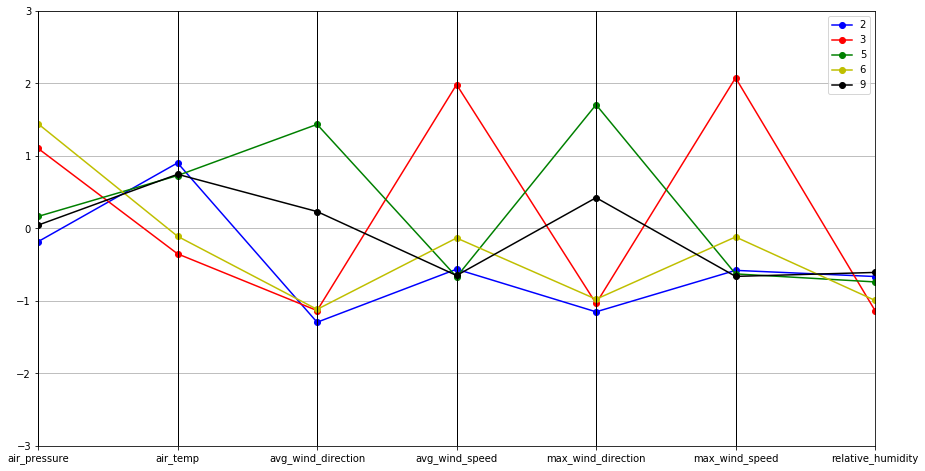

In [96]:
parallel_plot(P[P['relative_humidity'] < -0.5])

Notice that the X axis
denotes each of the seven features
we used for clustering, the values for them,
and the Y axis denotes the values of each cluster center.
So we have the labels in the X axis for the features,
and the values in the Y axis.
<br><br>
We can now, after we plotted them,
we can compare these clusters,
which clusters are similar, which are not.
Remember we are doing clustering for the features
we selected in the features list,
including relative humidity, like we selected here,
and air temperature.

# Warm Days

For each of the three plots, we show dry days,
relative humidity is less than zero five,
warm days, the air temperature is above zero point five.
Remember this data is scaled.

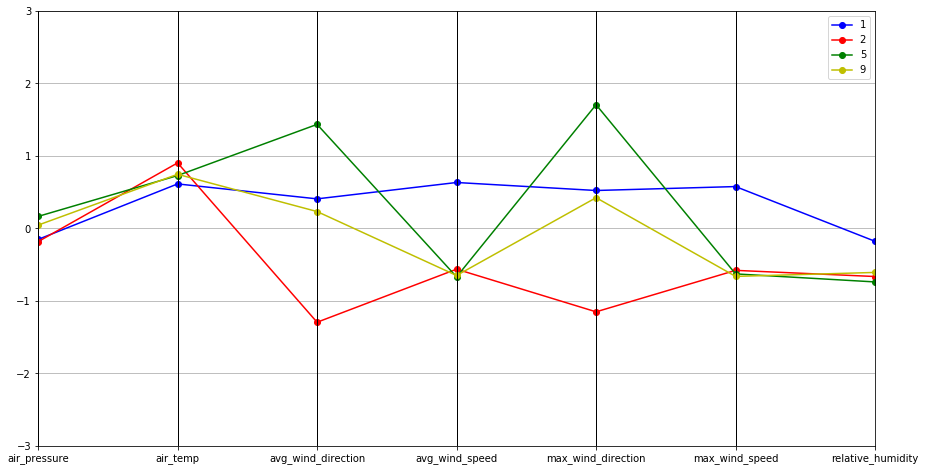

In [97]:
parallel_plot(P[P['air_temp'] > 0.5])

# Cool Days

the cool day is a combination of
relative humidity above zero point five,
and air temperature below zero point five.

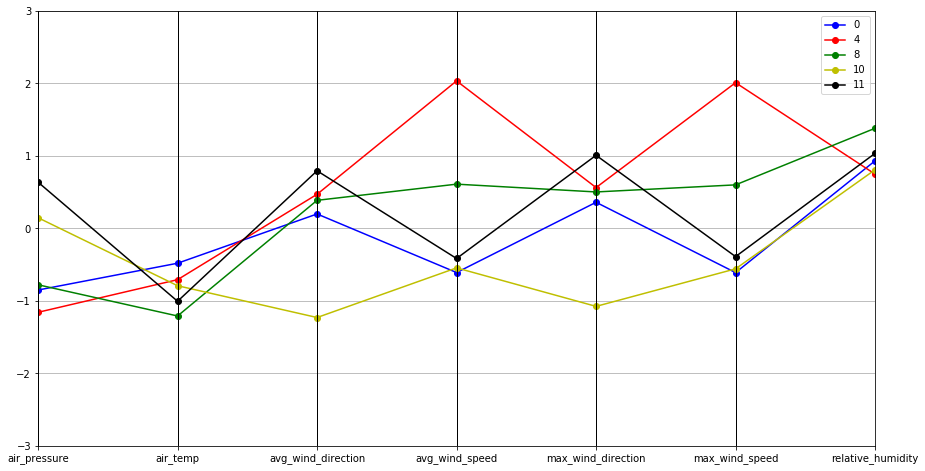

In [98]:
parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp'] < 0.5)])

So these are the clusters that have the behavior, so to say,
of dry days, warm days, and cool days.
<br><br>
For example, let's look at red and blue clusters
in each graph.
If you follow the cluster line for red
and blue clusters in each graph,
you can notice that they're close to each other
for a few features, and far apart on others.
If they differ on a particular feature,
this is one of the features which is likely helpful
to distinguish this cluster from others.
For example, red and blue are pretty far here,
far here, far here, closer here.
So they are pretty different two clusters, right?
They are different clusters, but how different
and which features are different for,
this plot will help us to identify that.
For the dry days graph, the differences are in,
as we looked at, air pressure, air temperature,
features related to wind speed.
So they are pretty different.
Let's look at the warm days, if they are closer
than for dry days.
If you follow the two lines and look at the labels,
looks like they actually differ for all features
related to wind.
And in the cool days graph, they vary for most features,
if you look at that, related to wind speed, right.
These are pretty similar up to the point,
the moment we look at average wind and maximum wind speed,
we see that they are different.
So remember that these parallel feature plots
are really useful for analyzing clusters,
which we have high dimensionality of features
to gain an intuition about how these clusters differ.
Feel free to play around with this notebook more,
to see if you can get a better feel for what each cluster is
from a weather standpoint.
<br><br>
To me, for example, cluster four seems to correspond to hot
and dry days with fairly stagnant air.
So just look at them and try to imagine the air
on that day, and how you could further now
use this information.
<br><br>
The objective of customering in this case is to characterize different weather patterns for a region (san diego)
